In [ ]:
## Objective

# This notebook analyzes multi-cloud (GCP, AWS, Azure) billing data to identify cost-saving opportunities and usage trends across services, accounts, and time.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.expanduser("~/.secrets/cloudops-analyzer.json")

In [2]:
from google.cloud import bigquery

client = bigquery.Client()

query = """
SELECT *
FROM `cloudops-analyzer.finops_sim.gcp_billing`
WHERE start_time >= '2025-01-01'
ORDER BY start_time ASC
LIMIT 1000

"""

df = client.query(query).to_dataframe()
df.head()

,project,service,sku,usage_type,region,cost,usage_amount,start_time
0,prod-video,BigQuery,Premium,CUD,europe-west1,638.34,408.09,2025-06-01
1,prod-video,Compute Engine,Premium,OnDemand,us-east1,764.17,1686.95,2025-06-01
2,prod-video,Cloud Storage,Premium,OnDemand,us-east1,278.09,447.40,2025-06-01
3,eng-streaming,Compute Engine,Premium,OnDemand,us-central1,447.96,955.04,2025-06-01
4,dev-ml,Cloud Storage,Standard,CUD,us-central1,203.39,1872.52,2025-06-01


In [3]:
# 1. View schema and null counts
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   project       450 non-null    object 
 1   service       450 non-null    object 
 2   sku           450 non-null    object 
 3   usage_type    450 non-null    object 
 4   region        450 non-null    object 
 5   cost          450 non-null    float64
 6   usage_amount  450 non-null    float64
 7   start_time    450 non-null    dbdate 
dtypes: dbdate(1), float64(2), object(5)
memory usage: 28.2+ KB


project         0
service         0
sku             0
usage_type      0
region          0
cost            0
usage_amount    0
start_time      0
dtype: int64

In [4]:
# 2. Basic descriptive stats
display(df.describe(include='all'))

,project,service,sku,usage_type,region,cost,usage_amount,start_time
count,450,450,450,450,450,450.000000,450.000000,450
unique,4,4,2,2,3,NaN,NaN,30
top,shared-data,Cloud Storage,Standard,OnDemand,us-east1,NaN,NaN,2025-06-01
freq,120,137,228,227,167,NaN,NaN,15
mean,NaN,NaN,NaN,NaN,NaN,412.358822,995.799200,NaN
std,NaN,NaN,NaN,NaN,NaN,223.113216,582.242303,NaN
min,NaN,NaN,NaN,NaN,NaN,20.750000,51.090000,NaN
25%,NaN,NaN,NaN,NaN,NaN,229.362500,477.490000,NaN
50%,NaN,NaN,NaN,NaN,NaN,425.745000,984.570000,NaN
75%,NaN,NaN,NaN,NaN,NaN,599.977500,1509.822500,NaN


In [5]:
# 3. Unique values per column
df.nunique()

project           4
service           4
sku               2
usage_type        2
region            3
cost            448
usage_amount    450
start_time       30
dtype: int64

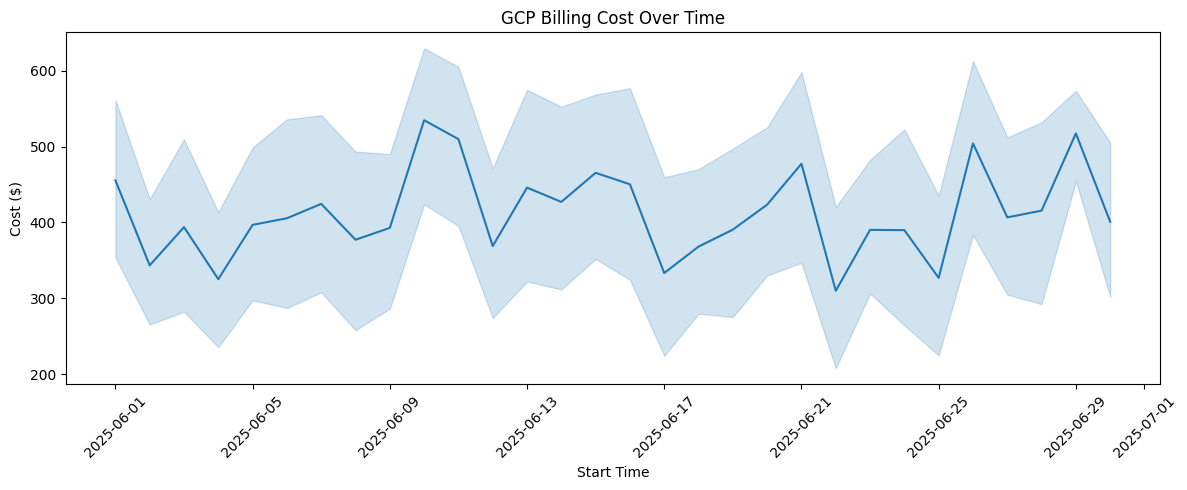

In [6]:
# Cost over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=df.sort_values("start_time"), x="start_time", y="cost")
plt.title("GCP Billing Cost Over Time")
plt.xlabel("Start Time")
plt.ylabel("Cost ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

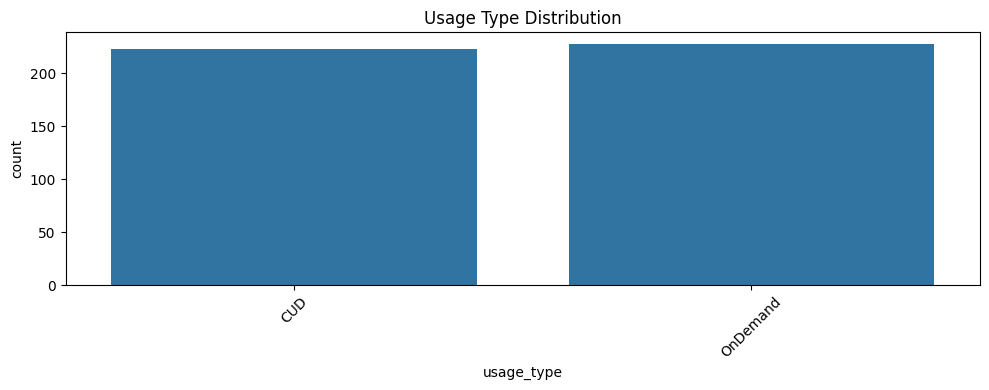

In [7]:
# Usage type distribution
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='usage_type')
plt.title("Usage Type Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

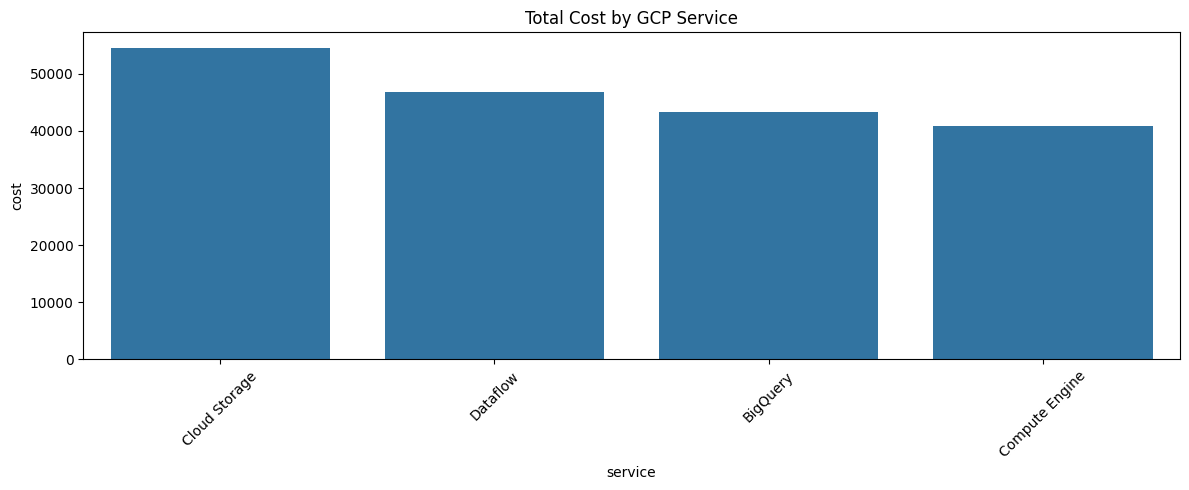

In [8]:
# Cost by service
plt.figure(figsize=(12, 5))
sns.barplot(data=df.groupby("service")["cost"].sum().reset_index().sort_values("cost", ascending=False), x="service", y="cost")
plt.title("Total Cost by GCP Service")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

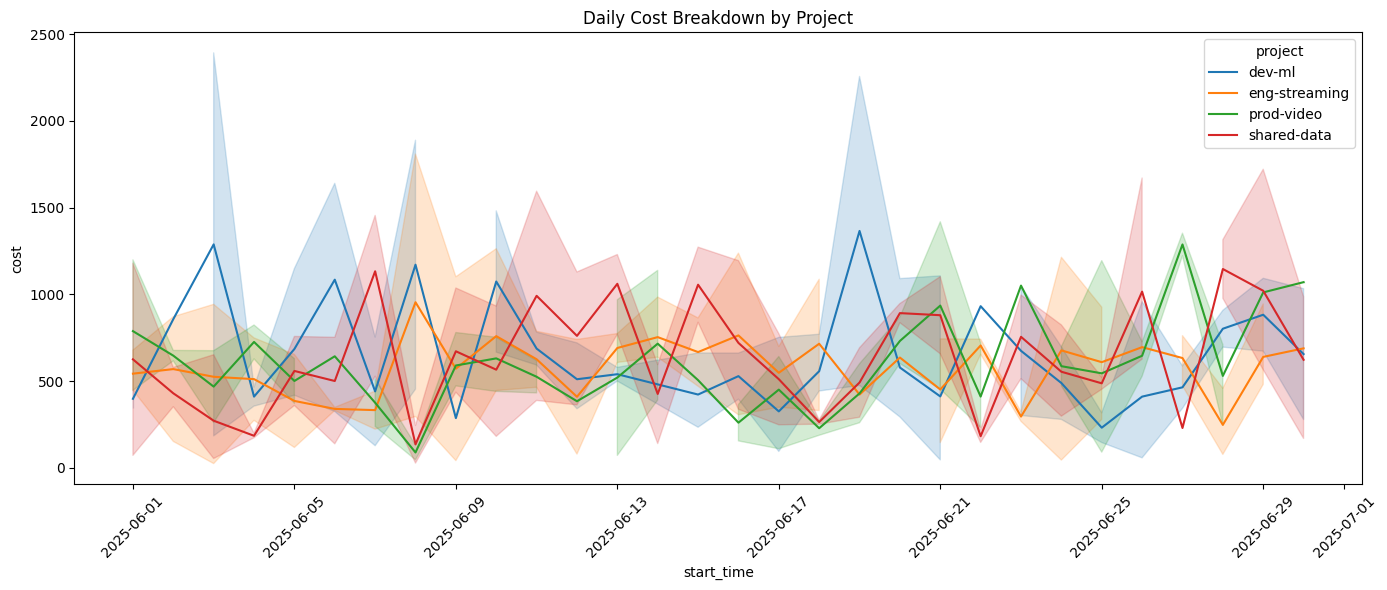

In [9]:
# Daily Cost Breakdown by Project + Service
daily_cost = (
    df.groupby(["start_time", "project", "service"])["cost"]
    .sum()
    .reset_index()
)
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_cost, x="start_time", y="cost", hue="project")
plt.title("Daily Cost Breakdown by Project")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


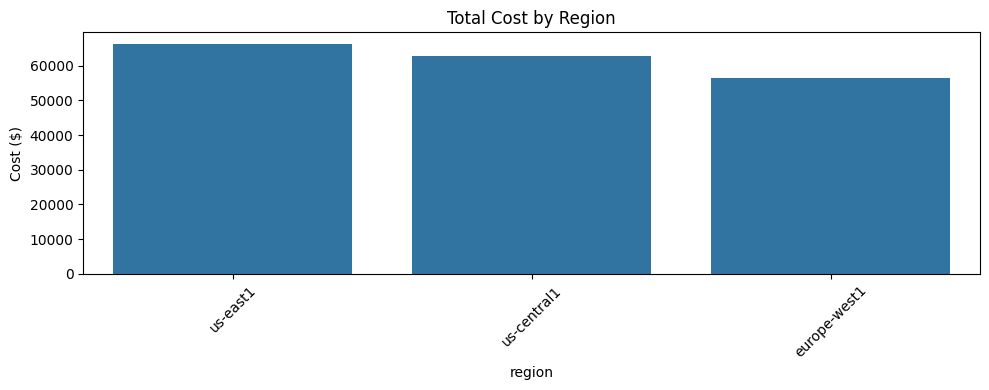

In [10]:
# High-Spend Regions & Anomalies

region_costs = df.groupby("region")["cost"].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(x=region_costs.index, y=region_costs.values)
plt.title("Total Cost by Region")
plt.ylabel("Cost ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 34.8 MB/s eta 0:00:00m eta 0:00:010:00:01


In [13]:
# Detect Potential Anomalies (spikes)

from scipy.stats import zscore
df["cost_zscore"] = zscore(df["cost"])
anomalies = df[df["cost_zscore"].abs() > 2]
display(anomalies[["project", "service", "region", "cost", "start_time", "cost_zscore"]])

,project,service,region,cost,start_time,cost_zscore


In [14]:
import openai
from dotenv import load_dotenv
import os

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [16]:
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
models = client.models.list()
print(models)

SyncPage[Model](data=[Model(id='gpt-4-0613', created=1686588896, object='model', owned_by='openai'), Model(id='gpt-4', created=1687882411, object='model', owned_by='openai'), Model(id='gpt-3.5-turbo', created=1677610602, object='model', owned_by='openai'), Model(id='o4-mini-deep-research-2025-06-26', created=1750866121, object='model', owned_by='system'), Model(id='codex-mini-latest', created=1746673257, object='model', owned_by='system'), Model(id='gpt-4o-realtime-preview-2025-06-03', created=1748907838, object='model', owned_by='system'), Model(id='gpt-4o-audio-preview-2025-06-03', created=1748908498, object='model', owned_by='system'), Model(id='o4-mini-deep-research', created=1749685485, object='model', owned_by='system'), Model(id='davinci-002', created=1692634301, object='model', owned_by='system'), Model(id='babbage-002', created=1692634615, object='model', owned_by='system'), Model(id='gpt-3.5-turbo-instruct', created=1692901427, object='model', owned_by='system'), Model(id='gp

In [18]:
import openai
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

insight_prompt = f"""
You are a FinOps Analyst. Analyze the following GCP billing summary:

- Top Services by Cost: {df.groupby("service")["cost"].sum().sort_values(ascending=False).head(3).to_dict()}
- Top Projects by Daily Cost: {df.groupby("project")["cost"].mean().sort_values(ascending=False).head(3).to_dict()}
- Usage Types: {df["usage_type"].value_counts().to_dict()}
- Regions by Cost: {df.groupby("region")["cost"].sum().sort_values(ascending=False).to_dict()}
- Detected anomalies (z-score > 2): {anomalies[["project", "cost", "cost_zscore"]].to_dict('records')}

Give a concise, executive-level summary of findings and recommendations.
"""

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "user", "content": insight_prompt}
    ],
    temperature=0.4
)

print(response.choices[0].message.content)

Summary:

The Google Cloud Platform (GCP) billing summary reveals that the top three services by cost are Cloud Storage ($54,551.11), Dataflow ($46,856.42), and BigQuery ($43,266.76). The projects with the highest daily costs are 'shared-data' ($428.38), 'dev-ml' ($415.23), and 'prod-video' ($403.51). The usage types are evenly split between OnDemand and CUD, with 227 and 223 instances respectively. The regions with the highest costs are 'us-east1' ($66,301.81), 'us-central1' ($62,717.99), and 'europe-west1' ($56,541.67). There were no detected anomalies in the billing data.

Recommendations:

Given that Cloud Storage is the most expensive service, it would be beneficial to review the usage and see if there are any opportunities for cost optimization. This could include deleting unnecessary data, moving infrequently accessed data to a lower-cost storage class, or even considering other storage solutions.

Similarly, for the 'shared-data', 'dev-ml', and 'prod-video' projects, a detailed